## Import Libraries

In [ ]:
import os
import glob
import random
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import make_grid
import torchvision.transforms as tt
import albumentations as A
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [ ]:
def set_seed(seed = 0):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()

## Load files path in a dataframe

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alekseimedvedev","key":"e7e2e8ad9f177293686bb5c420c22c41"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

100% 713M/714M [00:35<00:00, 23.5MB/s]
100% 714M/714M [00:35<00:00, 21.0MB/s]


In [ ]:
! unzip '/content/lgg-mri-segmentation.zip' -d '/content/lgg-mri-segmentation'

In [ ]:
ROOT_PATH = '/content/lgg-mri-segmentation/kaggle_3m/'

mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

files_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})

files_df

image_path  \
0     /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1     /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
2     /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3     /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
4     /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
...                                                 ...   
3924  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3925  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3926  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3927  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3928  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   

                                              mask_path  diagnosis  
0     /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          0  
1     /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          0  
2     /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          1  
3     /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          0  
4     /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          0  
...                                                 ...        ...  
3924  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          1  
3925  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          1  
3926  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          0  
3927  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          0  
3928  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          0  

[3929 rows x 3 columns]

## Understand data distribution

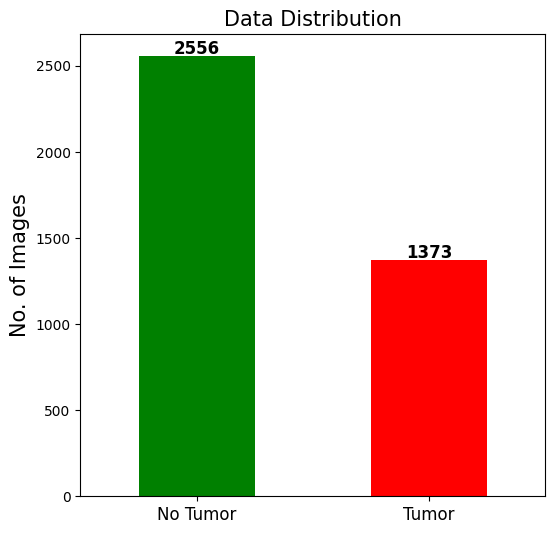

In [ ]:
ax = files_df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(6,6), color=['green', 'red'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('No. of Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(files_df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=12)

## Train-Validation-Test split

In [ ]:
train_df, val_df = train_test_split(files_df, stratify=files_df['diagnosis'], test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


## Viewing the dataset

(-0.5, 1279.5, 255.5, -0.5)

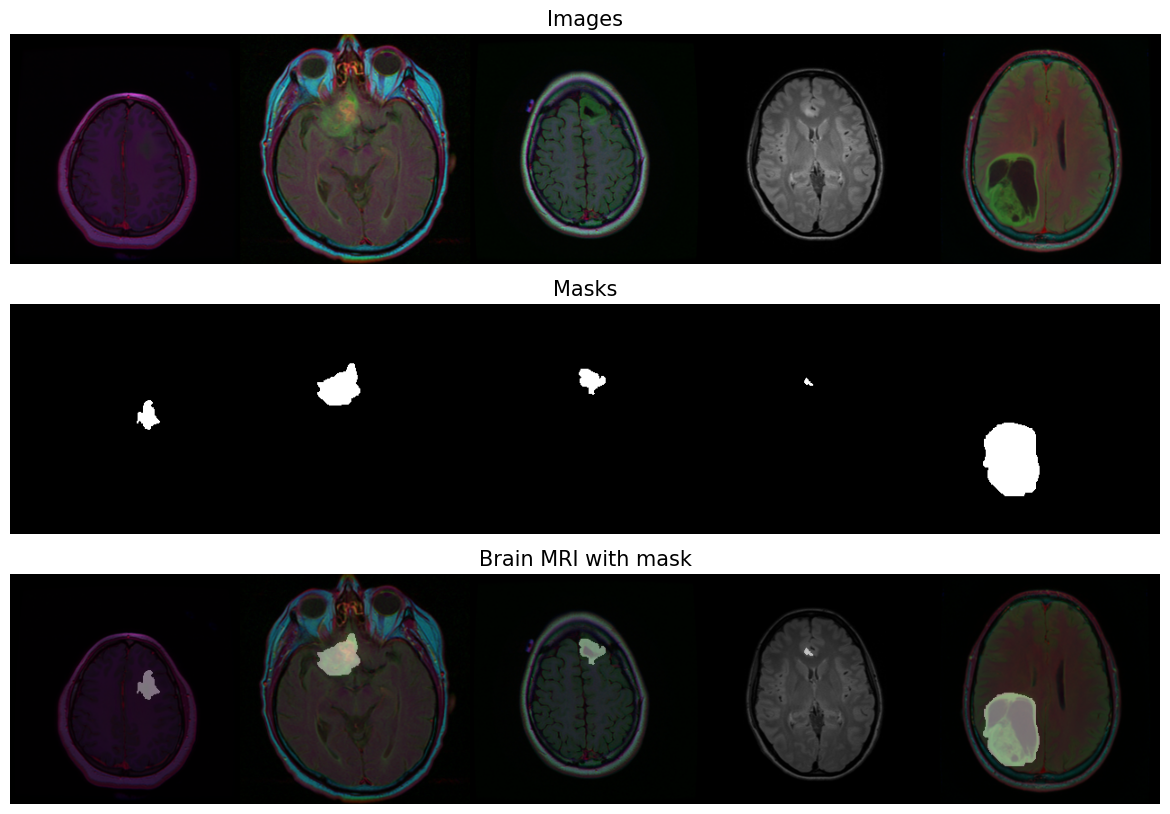

In [ ]:
set_seed()

images, masks = [], []
df_positive = train_df[train_df['diagnosis']==1].sample(5).values

for sample in df_positive:
    img = cv2.imread(sample[0])
    mask = cv2.imread(sample[1])
    images.append(img)
    masks.append(mask)
images = np.hstack(np.array(images))
masks = np.hstack(np.array(masks))

fig = plt.figure(figsize=(15,10))
grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.4)

grid[0].imshow(images)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')
grid[1].imshow(masks)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')
grid[2].imshow(images)
grid[2].imshow(masks, alpha=0.4)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')

## Converting to PyTorch dataset format

In [ ]:
class BrainDataset(data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)/255.
        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.

        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        image = image.transpose((2,0,1))
        image = torch.from_numpy(image).type(torch.float32)
        image = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)

        return image, mask

### Augmentations

In [ ]:
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
])

val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
])

test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0)
])

In [ ]:
set_seed()

train_ds = BrainDataset(train_df, train_transform)
val_ds = BrainDataset(val_df, val_transform)
test_ds = BrainDataset(test_df, test_transform)

In [ ]:
def dataset_info(dataset):
    print(f'Size of dataset: {len(dataset)}')
    index = random.randint(1, 40)
    img, label = dataset[index]
    print(f'Sample-{index} Image size: {img.shape}, Mask: {label.shape}\n')

In [ ]:
print('Train dataset:')
dataset_info(train_ds)
print('Validation dataset:')
dataset_info(val_ds)
print('Test dataset:')
dataset_info(test_ds)

Train dataset:
Size of dataset: 3005
Sample-25 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Validation dataset:
Size of dataset: 393
Sample-23 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Test dataset:
Size of dataset: 531
Sample-19 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])



## Creating Dataloaders

In [ ]:
batch_size = 32

set_seed()
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)

set_seed()
val_dl = DataLoader(val_ds,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)

test_dl = DataLoader(val_ds,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)

In [ ]:
images, masks = next(iter(train_dl))
print(images.shape)
print(masks.shape)

torch.Size([32, 3, 128, 128])
torch.Size([32, 1, 128, 128])


### Viewing samples from a batch

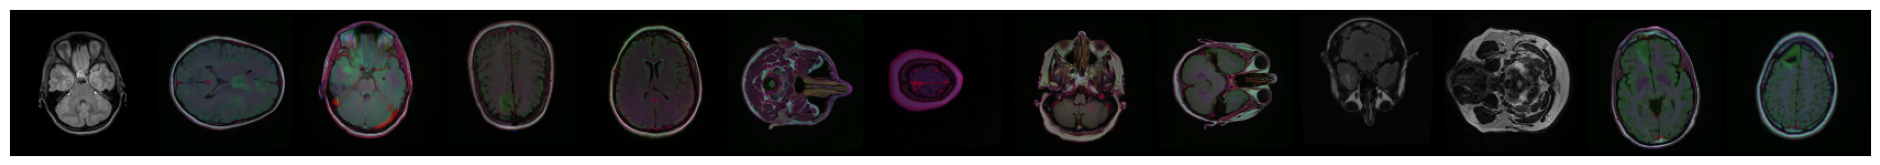

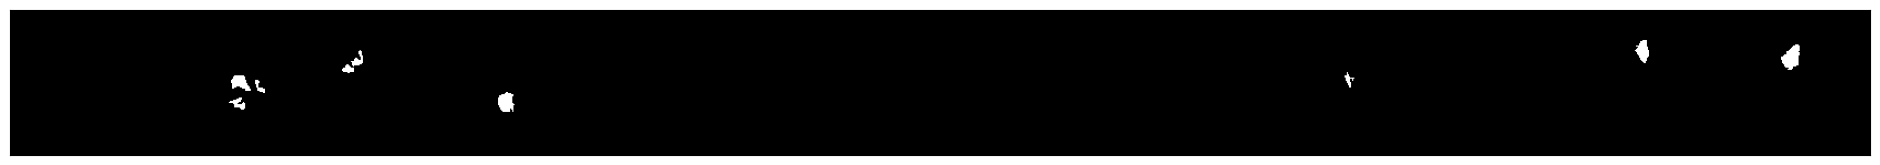

In [ ]:
def denormalize(images):
    means = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    stds = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, masks in dl:
        fig1, ax1 = plt.subplots(figsize=(24, 24))
        ax1.set_xticks([]); ax1.set_yticks([])
        denorm_images = denormalize(images)
        ax1.imshow(make_grid(denorm_images[:13], nrow=13).permute(1, 2, 0).clamp(0,1))

        fig2, ax2 = plt.subplots(figsize=(24, 24))
        ax2.set_xticks([]); ax2.set_yticks([])
        ax2.imshow(make_grid(masks[:13], nrow=13).permute(1, 2, 0).clamp(0,1))
        break

show_batch(train_dl)

## Defining the UNET model

In [ ]:
! pip install efficientunet-pytorch

In [ ]:
from efficientunet import *

model = get_efficientunet_b0(out_channels=1, concat_input=True, pretrained=True)
model.to(device);

In [ ]:
! pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model,input_size=(1, 3, 128, 128))

Layer (type:depth-idx)                        Output Shape              Param #
EfficientUnet                                 [1, 1, 128, 128]          --
├─Encoder: 1-1                                [1, 1280, 4, 4]           --
│    └─Conv2dSamePadding: 2-1                 [1, 32, 64, 64]           864
│    └─BatchNorm2d: 2-2                       [1, 32, 64, 64]           64
│    └─Swish: 2-3                             [1, 32, 64, 64]           --
│    └─ModuleList: 2-4                        --                        --
│    │    └─MBConvBlock: 3-1                  [1, 16, 64, 64]           1,448
│    │    └─MBConvBlock: 3-2                  [1, 24, 32, 32]           6,004
│    │    └─MBConvBlock: 3-3                  [1, 24, 32, 32]           10,710
│    │    └─MBConvBlock: 3-4                  [1, 40, 16, 16]           15,350
│    │    └─MBConvBlock: 3-5                  [1, 40, 16, 16]           31,290
│    │    └─MBConvBlock: 3-6                  [1, 80, 8, 8]             37,1

## Metric & Loss fn

In [ ]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(torch.sigmoid(pred), label)
    bce_loss = nn.BCEWithLogitsLoss()(pred, label)
    return dice_loss + bce_loss

## Training

### Train Loop

In [ ]:
def train_loop(model, loader, loss_func):
  model.train()
  train_losses = []
  train_dices = []

  for i, (image, mask) in enumerate(tqdm(loader)):
    image = image.to(device)
    mask = mask.to(device)
    outputs = model(image)
    out_cut = np.copy(outputs.data.cpu().numpy())
    out_cut[np.nonzero(out_cut < 0.5)] = 0.0
    out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

    dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
    loss = loss_func(outputs, mask)
    train_losses.append(loss.item())
    train_dices.append(dice)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return train_dices, train_losses

### Validation loop

In [ ]:
def eval_loop(model, loader, loss_func, training=True):
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for step, (image, mask) in enumerate(tqdm(loader)):
            image = image.to(device)
            mask = mask.to(device)

            outputs = model(image)
            loss = loss_func(outputs, mask)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())

            val_loss += loss
            val_dice += dice

        val_mean_dice = val_dice / step
        val_mean_loss = val_loss / step

        if training:
            scheduler.step(val_mean_dice)

    return val_mean_dice, val_mean_loss

### Train Function

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
early_stopper = EarlyStopper(patience=5, min_delta=0.05) # внимательней, советую 0.01 или 0.05
def train_model(train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs):
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []

    for epoch in range(num_epochs):
        train_dices, train_losses = train_loop(model, train_loader, loss_func)
        train_mean_dice = np.array(train_dices).mean()
        train_mean_loss = np.array(train_losses).mean()
        val_mean_dice, val_mean_loss = eval_loop(model, val_loader, loss_func)

        if early_stopper.early_stop(val_mean_loss):
          break

        train_loss_history.append(np.array(train_losses).mean())
        train_dice_history.append(np.array(train_dices).mean())
        val_loss_history.append(val_mean_loss)
        val_dice_history.append(val_mean_dice)

        print('Epoch: {}/{} |  Train Loss: {:.3f}, Val Loss: {:.3f}, Train DICE: {:.3f}, Val DICE: {:.3f}'.format(epoch+1, num_epochs,
                                                                                                                 train_mean_loss,
                                                                                                                 val_mean_loss,
                                                                                                                 train_mean_dice,
                                                                                                                 val_mean_dice))


    return train_loss_history, train_dice_history, val_loss_history, val_dice_history

### Hyperparameters

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
num_epochs = 100

In [ ]:
%%time
train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model(train_dl, val_dl, bce_dice_loss, optimizer, scheduler, num_epochs)

100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch: 1/100 |  Train Loss: 1.136, Val Loss: 1.060, Train DICE: 0.632, Val DICE: 0.777


100%|██████████| 13/13 [00:01<00:00,  6.69it/s]


Epoch: 2/100 |  Train Loss: 0.767, Val Loss: 0.627, Train DICE: 0.729, Val DICE: 0.831


100%|██████████| 13/13 [00:01<00:00,  8.11it/s]


Epoch: 3/100 |  Train Loss: 0.402, Val Loss: 0.452, Train DICE: 0.780, Val DICE: 0.730


100%|██████████| 13/13 [00:02<00:00,  5.47it/s]


Epoch: 4/100 |  Train Loss: 0.260, Val Loss: 0.551, Train DICE: 0.807, Val DICE: 0.600


100%|██████████| 13/13 [00:01<00:00,  7.03it/s]


Epoch: 5/100 |  Train Loss: 0.209, Val Loss: 0.227, Train DICE: 0.833, Val DICE: 0.901


100%|██████████| 13/13 [00:01<00:00,  8.26it/s]


Epoch: 6/100 |  Train Loss: 0.195, Val Loss: 0.186, Train DICE: 0.838, Val DICE: 0.931


100%|██████████| 13/13 [00:01<00:00,  7.44it/s]


Epoch: 7/100 |  Train Loss: 0.173, Val Loss: 0.267, Train DICE: 0.854, Val DICE: 0.855


100%|██████████| 13/13 [00:01<00:00,  8.25it/s]


Epoch: 8/100 |  Train Loss: 0.168, Val Loss: 0.158, Train DICE: 0.857, Val DICE: 0.948


100%|██████████| 13/13 [00:02<00:00,  5.73it/s]


Epoch: 9/100 |  Train Loss: 0.152, Val Loss: 0.180, Train DICE: 0.869, Val DICE: 0.929


100%|██████████| 13/13 [00:01<00:00,  8.00it/s]


Epoch: 10/100 |  Train Loss: 0.147, Val Loss: 0.155, Train DICE: 0.872, Val DICE: 0.949


100%|██████████| 13/13 [00:01<00:00,  7.06it/s]


Epoch: 11/100 |  Train Loss: 0.149, Val Loss: 0.148, Train DICE: 0.871, Val DICE: 0.955


100%|██████████| 13/13 [00:01<00:00,  7.92it/s]


Epoch: 12/100 |  Train Loss: 0.137, Val Loss: 0.148, Train DICE: 0.880, Val DICE: 0.957


100%|██████████| 13/13 [00:01<00:00,  8.34it/s]


Epoch: 13/100 |  Train Loss: 0.139, Val Loss: 0.165, Train DICE: 0.878, Val DICE: 0.938


100%|██████████| 13/13 [00:01<00:00,  7.92it/s]


Epoch: 14/100 |  Train Loss: 0.139, Val Loss: 0.138, Train DICE: 0.877, Val DICE: 0.963


100%|██████████| 13/13 [00:01<00:00,  8.24it/s]


Epoch: 15/100 |  Train Loss: 0.132, Val Loss: 0.129, Train DICE: 0.884, Val DICE: 0.971


100%|██████████| 13/13 [00:02<00:00,  5.09it/s]


Epoch: 16/100 |  Train Loss: 0.130, Val Loss: 0.130, Train DICE: 0.885, Val DICE: 0.971


100%|██████████| 13/13 [00:01<00:00,  7.83it/s]


Epoch: 17/100 |  Train Loss: 0.129, Val Loss: 0.172, Train DICE: 0.886, Val DICE: 0.931


100%|██████████| 13/13 [00:01<00:00,  8.04it/s]


Epoch: 18/100 |  Train Loss: 0.132, Val Loss: 0.140, Train DICE: 0.884, Val DICE: 0.961


100%|██████████| 13/13 [00:01<00:00,  8.23it/s]


Epoch: 19/100 |  Train Loss: 0.131, Val Loss: 0.139, Train DICE: 0.885, Val DICE: 0.960


100%|██████████| 13/13 [00:01<00:00,  7.53it/s]


Epoch: 20/100 |  Train Loss: 0.121, Val Loss: 0.126, Train DICE: 0.893, Val DICE: 0.972


100%|██████████| 13/13 [00:01<00:00,  6.73it/s]


Epoch: 21/100 |  Train Loss: 0.117, Val Loss: 0.130, Train DICE: 0.896, Val DICE: 0.969


100%|██████████| 13/13 [00:01<00:00,  8.36it/s]


Epoch: 22/100 |  Train Loss: 0.116, Val Loss: 0.128, Train DICE: 0.897, Val DICE: 0.971


100%|██████████| 13/13 [00:02<00:00,  5.58it/s]


Epoch: 23/100 |  Train Loss: 0.117, Val Loss: 0.127, Train DICE: 0.897, Val DICE: 0.972


100%|██████████| 13/13 [00:01<00:00,  8.16it/s]


Epoch: 24/100 |  Train Loss: 0.114, Val Loss: 0.121, Train DICE: 0.899, Val DICE: 0.976


100%|██████████| 13/13 [00:01<00:00,  6.64it/s]


Epoch: 25/100 |  Train Loss: 0.116, Val Loss: 0.123, Train DICE: 0.897, Val DICE: 0.975


100%|██████████| 13/13 [00:01<00:00,  8.27it/s]


Epoch: 26/100 |  Train Loss: 0.114, Val Loss: 0.120, Train DICE: 0.899, Val DICE: 0.977


100%|██████████| 13/13 [00:01<00:00,  8.37it/s]


Epoch: 27/100 |  Train Loss: 0.113, Val Loss: 0.121, Train DICE: 0.900, Val DICE: 0.976


100%|██████████| 13/13 [00:01<00:00,  7.89it/s]


Epoch: 28/100 |  Train Loss: 0.109, Val Loss: 0.120, Train DICE: 0.904, Val DICE: 0.977


100%|██████████| 13/13 [00:01<00:00,  8.27it/s]


Epoch: 29/100 |  Train Loss: 0.112, Val Loss: 0.118, Train DICE: 0.901, Val DICE: 0.979


100%|██████████| 13/13 [00:02<00:00,  5.11it/s]


Epoch: 30/100 |  Train Loss: 0.113, Val Loss: 0.119, Train DICE: 0.900, Val DICE: 0.978


100%|██████████| 13/13 [00:01<00:00,  8.11it/s]


Epoch: 31/100 |  Train Loss: 0.112, Val Loss: 0.117, Train DICE: 0.900, Val DICE: 0.980


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


Epoch: 32/100 |  Train Loss: 0.112, Val Loss: 0.115, Train DICE: 0.900, Val DICE: 0.982


100%|██████████| 13/13 [00:01<00:00,  7.94it/s]


Epoch: 33/100 |  Train Loss: 0.109, Val Loss: 0.118, Train DICE: 0.903, Val DICE: 0.980


100%|██████████| 13/13 [00:01<00:00,  8.20it/s]


Epoch: 34/100 |  Train Loss: 0.110, Val Loss: 0.121, Train DICE: 0.902, Val DICE: 0.977


100%|██████████| 13/13 [00:01<00:00,  8.24it/s]


Epoch: 35/100 |  Train Loss: 0.109, Val Loss: 0.115, Train DICE: 0.904, Val DICE: 0.981


100%|██████████| 13/13 [00:01<00:00,  8.18it/s]


Epoch: 36/100 |  Train Loss: 0.109, Val Loss: 0.116, Train DICE: 0.904, Val DICE: 0.981


100%|██████████| 13/13 [00:02<00:00,  5.99it/s]


Epoch: 37/100 |  Train Loss: 0.107, Val Loss: 0.115, Train DICE: 0.905, Val DICE: 0.982


100%|██████████| 13/13 [00:01<00:00,  8.31it/s]


Epoch: 38/100 |  Train Loss: 0.107, Val Loss: 0.117, Train DICE: 0.905, Val DICE: 0.980


100%|██████████| 13/13 [00:02<00:00,  5.83it/s]


Epoch: 39/100 |  Train Loss: 0.108, Val Loss: 0.118, Train DICE: 0.904, Val DICE: 0.979


100%|██████████| 13/13 [00:01<00:00,  8.04it/s]


Epoch: 40/100 |  Train Loss: 0.108, Val Loss: 0.115, Train DICE: 0.904, Val DICE: 0.982


100%|██████████| 13/13 [00:01<00:00,  7.90it/s]


Epoch: 41/100 |  Train Loss: 0.106, Val Loss: 0.118, Train DICE: 0.906, Val DICE: 0.979


100%|██████████| 13/13 [00:01<00:00,  8.21it/s]


Epoch: 42/100 |  Train Loss: 0.106, Val Loss: 0.114, Train DICE: 0.906, Val DICE: 0.982


100%|██████████| 13/13 [00:01<00:00,  8.36it/s]


Epoch: 43/100 |  Train Loss: 0.106, Val Loss: 0.115, Train DICE: 0.906, Val DICE: 0.982


100%|██████████| 13/13 [00:01<00:00,  7.74it/s]


Epoch: 44/100 |  Train Loss: 0.107, Val Loss: 0.117, Train DICE: 0.905, Val DICE: 0.980


100%|██████████| 13/13 [00:01<00:00,  8.30it/s]


Epoch: 45/100 |  Train Loss: 0.106, Val Loss: 0.115, Train DICE: 0.906, Val DICE: 0.982


100%|██████████| 13/13 [00:02<00:00,  5.41it/s]


Epoch: 46/100 |  Train Loss: 0.108, Val Loss: 0.117, Train DICE: 0.904, Val DICE: 0.979


100%|██████████| 13/13 [00:01<00:00,  8.32it/s]


Epoch: 47/100 |  Train Loss: 0.106, Val Loss: 0.116, Train DICE: 0.906, Val DICE: 0.981


100%|██████████| 13/13 [00:01<00:00,  7.32it/s]


Epoch: 48/100 |  Train Loss: 0.108, Val Loss: 0.116, Train DICE: 0.904, Val DICE: 0.980


100%|██████████| 13/13 [00:01<00:00,  8.40it/s]


Epoch: 49/100 |  Train Loss: 0.106, Val Loss: 0.118, Train DICE: 0.906, Val DICE: 0.979


100%|██████████| 13/13 [00:01<00:00,  8.29it/s]


Epoch: 50/100 |  Train Loss: 0.107, Val Loss: 0.114, Train DICE: 0.905, Val DICE: 0.982


100%|██████████| 13/13 [00:01<00:00,  8.24it/s]


Epoch: 51/100 |  Train Loss: 0.105, Val Loss: 0.115, Train DICE: 0.907, Val DICE: 0.982


100%|██████████| 13/13 [00:01<00:00,  8.40it/s]


Epoch: 52/100 |  Train Loss: 0.106, Val Loss: 0.116, Train DICE: 0.906, Val DICE: 0.981


100%|██████████| 13/13 [00:02<00:00,  6.02it/s]


Epoch: 53/100 |  Train Loss: 0.109, Val Loss: 0.117, Train DICE: 0.903, Val DICE: 0.980


100%|██████████| 13/13 [00:01<00:00,  8.28it/s]


Epoch: 54/100 |  Train Loss: 0.109, Val Loss: 0.116, Train DICE: 0.903, Val DICE: 0.980


100%|██████████| 13/13 [00:02<00:00,  5.73it/s]


Epoch: 55/100 |  Train Loss: 0.107, Val Loss: 0.116, Train DICE: 0.905, Val DICE: 0.981


100%|██████████| 13/13 [00:01<00:00,  8.35it/s]


Epoch: 56/100 |  Train Loss: 0.105, Val Loss: 0.116, Train DICE: 0.906, Val DICE: 0.981


100%|██████████| 13/13 [00:01<00:00,  8.35it/s]


Epoch: 57/100 |  Train Loss: 0.106, Val Loss: 0.118, Train DICE: 0.906, Val DICE: 0.979


100%|██████████| 13/13 [00:01<00:00,  8.16it/s]


Epoch: 58/100 |  Train Loss: 0.106, Val Loss: 0.116, Train DICE: 0.906, Val DICE: 0.981


100%|██████████| 13/13 [00:01<00:00,  8.06it/s]


Epoch: 59/100 |  Train Loss: 0.107, Val Loss: 0.115, Train DICE: 0.905, Val DICE: 0.982


100%|██████████| 13/13 [00:01<00:00,  6.73it/s]


Epoch: 60/100 |  Train Loss: 0.109, Val Loss: 0.116, Train DICE: 0.903, Val DICE: 0.980


100%|██████████| 13/13 [00:01<00:00,  8.36it/s]


Epoch: 61/100 |  Train Loss: 0.108, Val Loss: 0.117, Train DICE: 0.904, Val DICE: 0.980


100%|██████████| 13/13 [00:02<00:00,  5.46it/s]


Epoch: 62/100 |  Train Loss: 0.105, Val Loss: 0.115, Train DICE: 0.907, Val DICE: 0.982


100%|██████████| 13/13 [00:01<00:00,  8.17it/s]


Epoch: 63/100 |  Train Loss: 0.106, Val Loss: 0.115, Train DICE: 0.906, Val DICE: 0.981


100%|██████████| 13/13 [00:01<00:00,  7.35it/s]


Epoch: 64/100 |  Train Loss: 0.106, Val Loss: 0.115, Train DICE: 0.906, Val DICE: 0.982


100%|██████████| 13/13 [00:01<00:00,  8.25it/s]


Epoch: 65/100 |  Train Loss: 0.107, Val Loss: 0.118, Train DICE: 0.905, Val DICE: 0.979


100%|██████████| 13/13 [00:01<00:00,  7.17it/s]


Epoch: 66/100 |  Train Loss: 0.105, Val Loss: 0.116, Train DICE: 0.907, Val DICE: 0.980


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


Epoch: 67/100 |  Train Loss: 0.106, Val Loss: 0.116, Train DICE: 0.906, Val DICE: 0.981


100%|██████████| 13/13 [00:01<00:00,  8.23it/s]


Epoch: 68/100 |  Train Loss: 0.107, Val Loss: 0.117, Train DICE: 0.905, Val DICE: 0.979


100%|██████████| 13/13 [00:02<00:00,  5.55it/s]


Epoch: 69/100 |  Train Loss: 0.107, Val Loss: 0.116, Train DICE: 0.905, Val DICE: 0.981


100%|██████████| 13/13 [00:01<00:00,  8.49it/s]


Epoch: 70/100 |  Train Loss: 0.107, Val Loss: 0.114, Train DICE: 0.905, Val DICE: 0.983


100%|██████████| 13/13 [00:02<00:00,  6.31it/s]


Epoch: 71/100 |  Train Loss: 0.106, Val Loss: 0.116, Train DICE: 0.906, Val DICE: 0.981


100%|██████████| 13/13 [00:01<00:00,  8.22it/s]


Epoch: 72/100 |  Train Loss: 0.108, Val Loss: 0.117, Train DICE: 0.904, Val DICE: 0.980


100%|██████████| 13/13 [00:01<00:00,  8.30it/s]


Epoch: 73/100 |  Train Loss: 0.107, Val Loss: 0.117, Train DICE: 0.905, Val DICE: 0.980


100%|██████████| 13/13 [00:01<00:00,  8.08it/s]


Epoch: 74/100 |  Train Loss: 0.105, Val Loss: 0.116, Train DICE: 0.907, Val DICE: 0.981


100%|██████████| 13/13 [00:01<00:00,  8.14it/s]


Epoch: 75/100 |  Train Loss: 0.105, Val Loss: 0.117, Train DICE: 0.907, Val DICE: 0.980


100%|██████████| 13/13 [00:02<00:00,  5.42it/s]


Epoch: 76/100 |  Train Loss: 0.107, Val Loss: 0.114, Train DICE: 0.905, Val DICE: 0.982


100%|██████████| 13/13 [00:01<00:00,  8.48it/s]


Epoch: 77/100 |  Train Loss: 0.105, Val Loss: 0.114, Train DICE: 0.906, Val DICE: 0.982


100%|██████████| 13/13 [00:02<00:00,  5.62it/s]


Epoch: 78/100 |  Train Loss: 0.108, Val Loss: 0.118, Train DICE: 0.904, Val DICE: 0.979


100%|██████████| 13/13 [00:01<00:00,  8.28it/s]


Epoch: 79/100 |  Train Loss: 0.106, Val Loss: 0.116, Train DICE: 0.906, Val DICE: 0.980


100%|██████████| 13/13 [00:01<00:00,  8.27it/s]


Epoch: 80/100 |  Train Loss: 0.106, Val Loss: 0.117, Train DICE: 0.906, Val DICE: 0.980


100%|██████████| 13/13 [00:01<00:00,  8.34it/s]


Epoch: 81/100 |  Train Loss: 0.109, Val Loss: 0.117, Train DICE: 0.903, Val DICE: 0.980


100%|██████████| 13/13 [00:02<00:00,  5.02it/s]


Epoch: 82/100 |  Train Loss: 0.108, Val Loss: 0.115, Train DICE: 0.904, Val DICE: 0.981


100%|██████████| 13/13 [00:02<00:00,  5.79it/s]


Epoch: 83/100 |  Train Loss: 0.105, Val Loss: 0.116, Train DICE: 0.907, Val DICE: 0.981


100%|██████████| 13/13 [00:01<00:00,  8.36it/s]


Epoch: 84/100 |  Train Loss: 0.107, Val Loss: 0.115, Train DICE: 0.905, Val DICE: 0.981


100%|██████████| 13/13 [00:01<00:00,  8.31it/s]


Epoch: 85/100 |  Train Loss: 0.106, Val Loss: 0.116, Train DICE: 0.906, Val DICE: 0.981


100%|██████████| 13/13 [00:01<00:00,  8.34it/s]


Epoch: 86/100 |  Train Loss: 0.106, Val Loss: 0.117, Train DICE: 0.906, Val DICE: 0.980


100%|██████████| 13/13 [00:02<00:00,  6.44it/s]


Epoch: 87/100 |  Train Loss: 0.108, Val Loss: 0.116, Train DICE: 0.904, Val DICE: 0.981


100%|██████████| 13/13 [00:01<00:00,  8.30it/s]


Epoch: 88/100 |  Train Loss: 0.107, Val Loss: 0.119, Train DICE: 0.905, Val DICE: 0.978


100%|██████████| 13/13 [00:02<00:00,  5.72it/s]


Epoch: 89/100 |  Train Loss: 0.108, Val Loss: 0.116, Train DICE: 0.904, Val DICE: 0.980


100%|██████████| 13/13 [00:01<00:00,  8.33it/s]


Epoch: 90/100 |  Train Loss: 0.107, Val Loss: 0.117, Train DICE: 0.905, Val DICE: 0.980


100%|██████████| 13/13 [00:01<00:00,  8.45it/s]


Epoch: 91/100 |  Train Loss: 0.108, Val Loss: 0.114, Train DICE: 0.904, Val DICE: 0.982


100%|██████████| 13/13 [00:02<00:00,  6.35it/s]


Epoch: 92/100 |  Train Loss: 0.107, Val Loss: 0.117, Train DICE: 0.905, Val DICE: 0.980


100%|██████████| 13/13 [00:01<00:00,  8.24it/s]


Epoch: 93/100 |  Train Loss: 0.106, Val Loss: 0.116, Train DICE: 0.906, Val DICE: 0.981


100%|██████████| 13/13 [00:02<00:00,  5.80it/s]


Epoch: 94/100 |  Train Loss: 0.106, Val Loss: 0.118, Train DICE: 0.906, Val DICE: 0.979


100%|██████████| 13/13 [00:01<00:00,  8.31it/s]


Epoch: 95/100 |  Train Loss: 0.108, Val Loss: 0.115, Train DICE: 0.904, Val DICE: 0.982


100%|██████████| 13/13 [00:02<00:00,  5.91it/s]


Epoch: 96/100 |  Train Loss: 0.106, Val Loss: 0.115, Train DICE: 0.906, Val DICE: 0.981


100%|██████████| 13/13 [00:01<00:00,  8.29it/s]


Epoch: 97/100 |  Train Loss: 0.106, Val Loss: 0.115, Train DICE: 0.906, Val DICE: 0.982


100%|██████████| 13/13 [00:01<00:00,  8.30it/s]


Epoch: 98/100 |  Train Loss: 0.105, Val Loss: 0.116, Train DICE: 0.906, Val DICE: 0.980


100%|██████████| 13/13 [00:01<00:00,  8.40it/s]


Epoch: 99/100 |  Train Loss: 0.109, Val Loss: 0.117, Train DICE: 0.904, Val DICE: 0.980


100%|██████████| 13/13 [00:01<00:00,  8.23it/s]

Epoch: 100/100 |  Train Loss: 0.107, Val Loss: 0.116, Train DICE: 0.905, Val DICE: 0.980
CPU times: user 31min 19s, sys: 1min 4s, total: 32min 23s
Wall time: 37min 48s


## DICE Score History

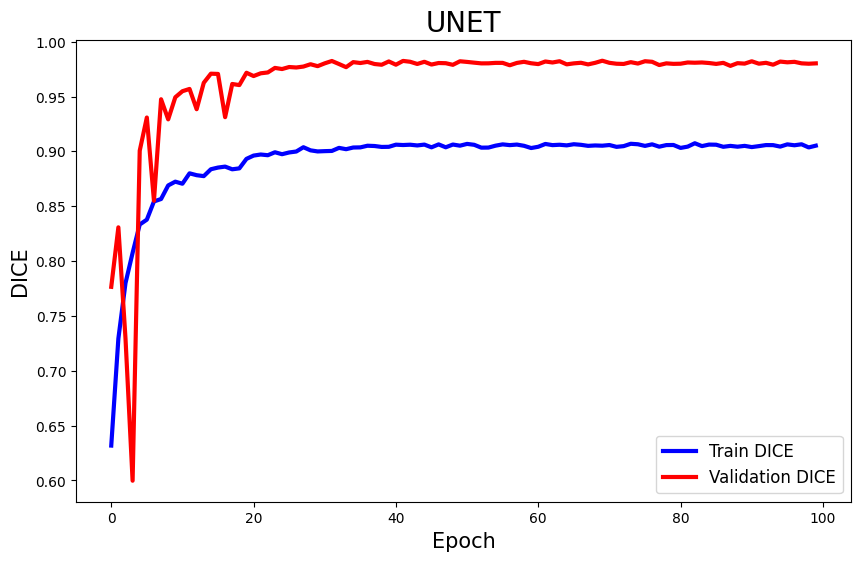

In [ ]:
def plot_dice_history(model_name, train_dice_history, val_dice_history, num_epochs):

    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_dice_history, label='Train DICE', lw=3, c="b")
    plt.plot(x, val_dice_history, label='Validation DICE', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.show()

plot_dice_history('UNET', train_dice_history, val_dice_history, num_epochs)

## Loss History

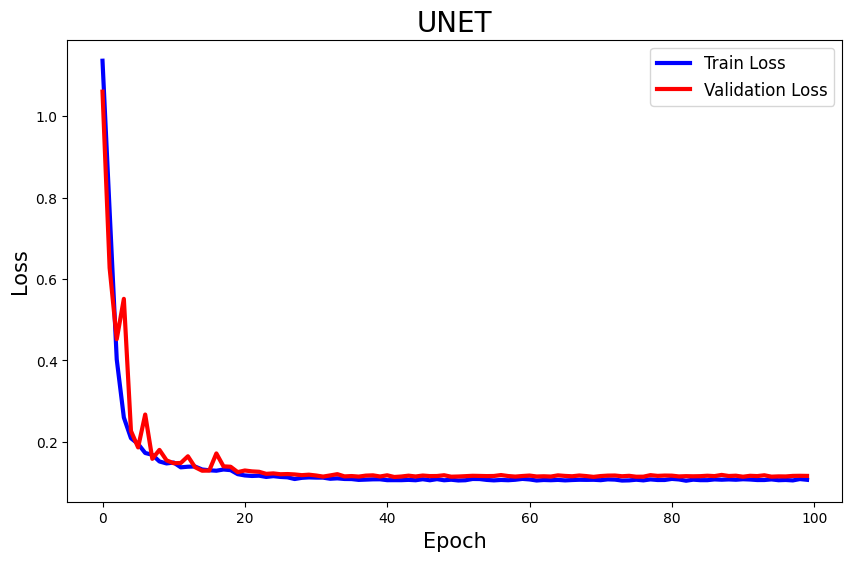

In [ ]:
def plot_loss_history(model_name, train_loss_history, val_loss_history, num_epochs):

    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_loss_history, label='Train Loss', lw=3, c="b")
    plt.plot(x, [x.cpu() for x in val_loss_history], label='Validation Loss', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.show()

plot_loss_history('UNET', train_loss_history, val_loss_history, num_epochs)

## Prediction on Test set

In [ ]:
%%time
test_dice, test_loss = eval_loop(model, test_dl, bce_dice_loss, training=False)
print("Mean IoU/DICE: {:.3f}%, Loss: {:.3f}".format((100*test_dice), test_loss))

100%|██████████| 13/13 [00:01<00:00,  8.20it/s]

Mean IoU/DICE: 98.104%, Loss: 0.115
CPU times: user 1.09 s, sys: 147 ms, total: 1.24 s
Wall time: 1.6 s


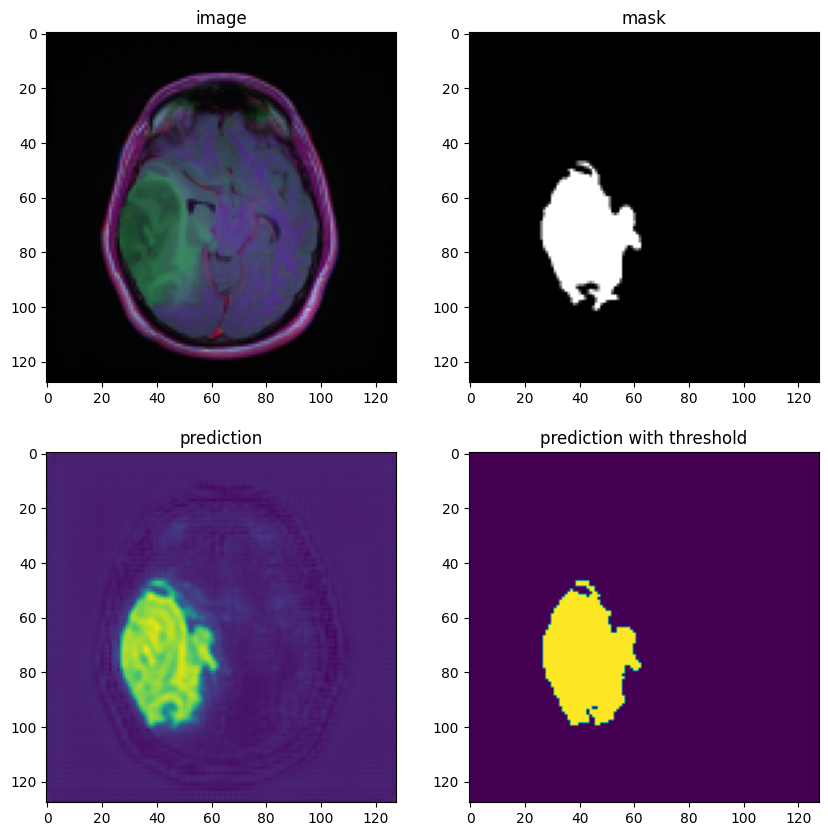

In [ ]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(24).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

## Saving the Model

In [ ]:
torch.save(model.state_dict(), 'brain-mri-unet.pth')

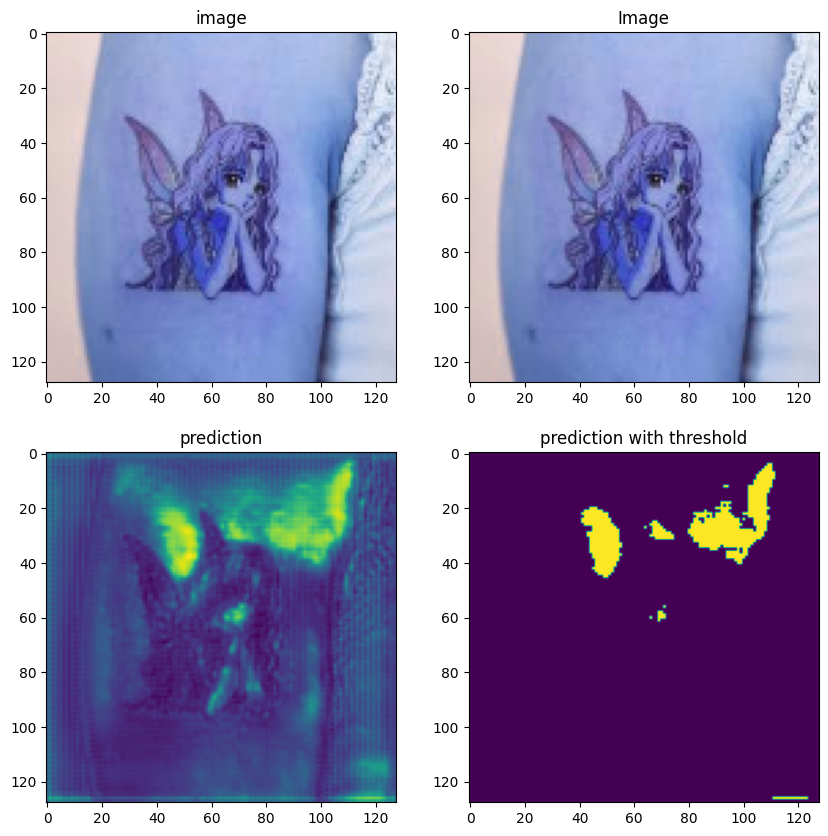

In [ ]:
image = cv2.imread("/content/mri_1.jpg", cv2.IMREAD_COLOR)
image = cv2.resize(image, (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(image)
ax[0, 1].set_title("Image")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

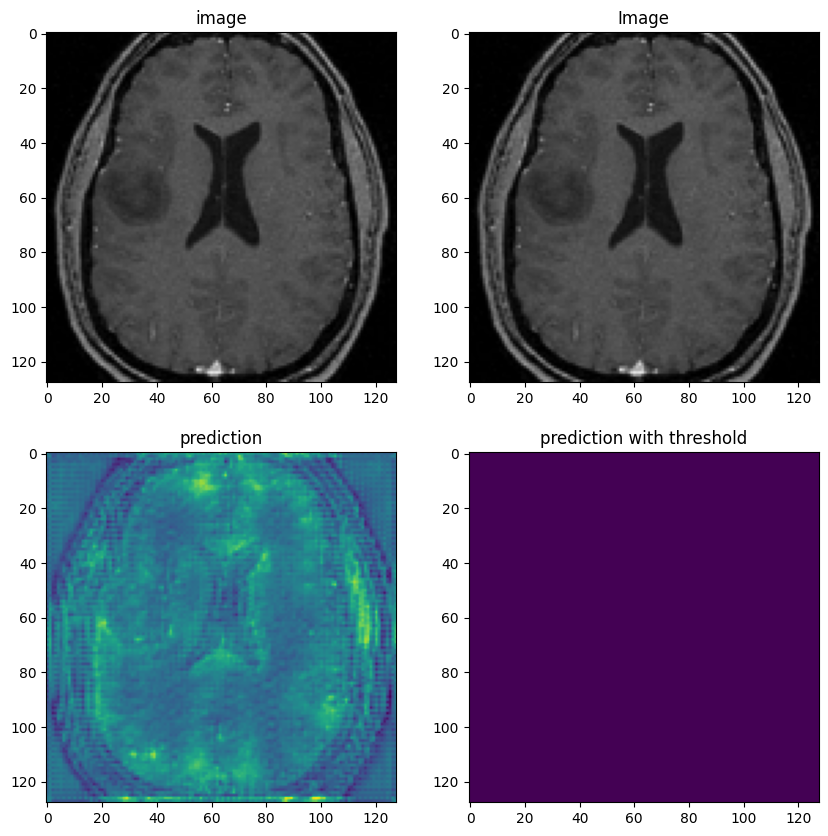

In [ ]:
image = cv2.imread("/content/mri_2.jpg", cv2.IMREAD_COLOR)
image = cv2.resize(image, (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(image)
ax[0, 1].set_title("Image")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

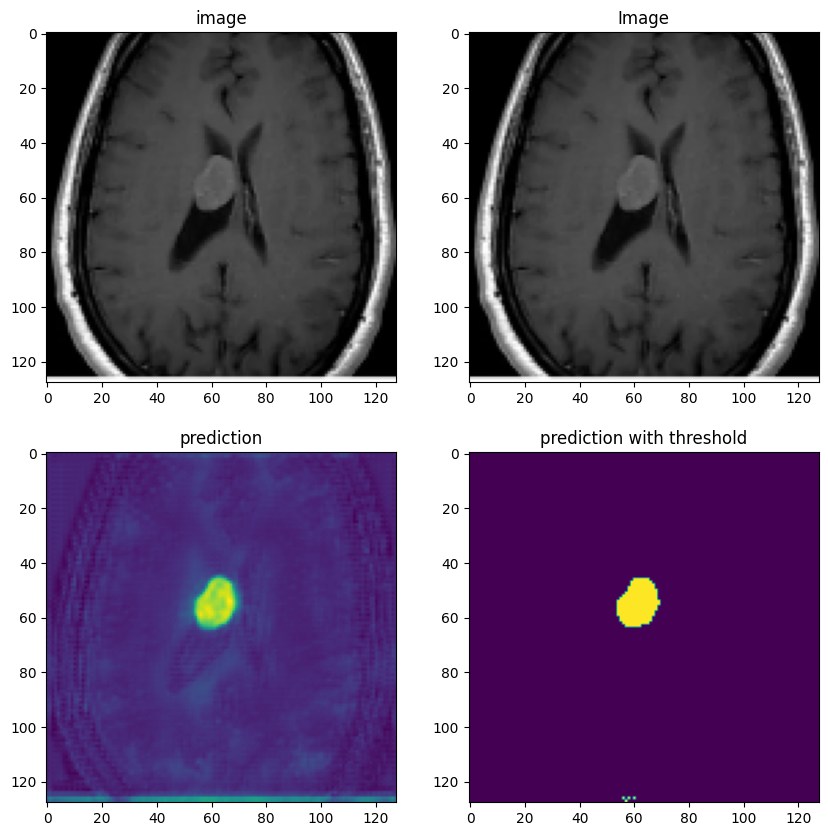

In [ ]:
image = cv2.imread("/content/mri_3.jpg", cv2.IMREAD_COLOR)
image = cv2.resize(image, (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(image)
ax[0, 1].set_title("Image")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

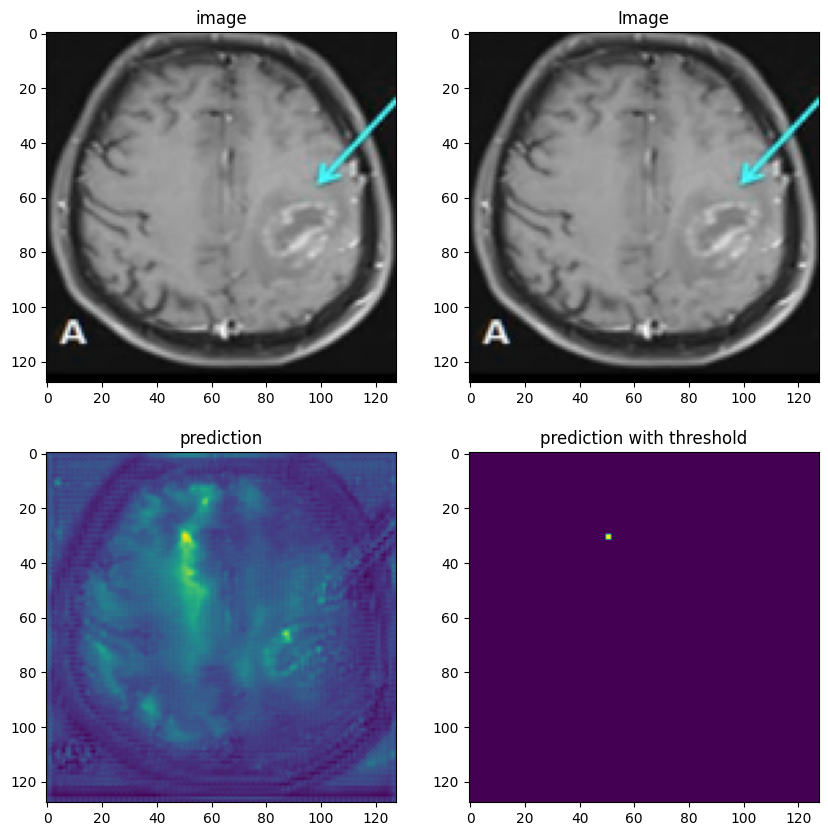

In [ ]:
image = cv2.imread("/content/mri_4.jpg", cv2.IMREAD_COLOR)
image = cv2.resize(image, (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(image)
ax[0, 1].set_title("Image")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

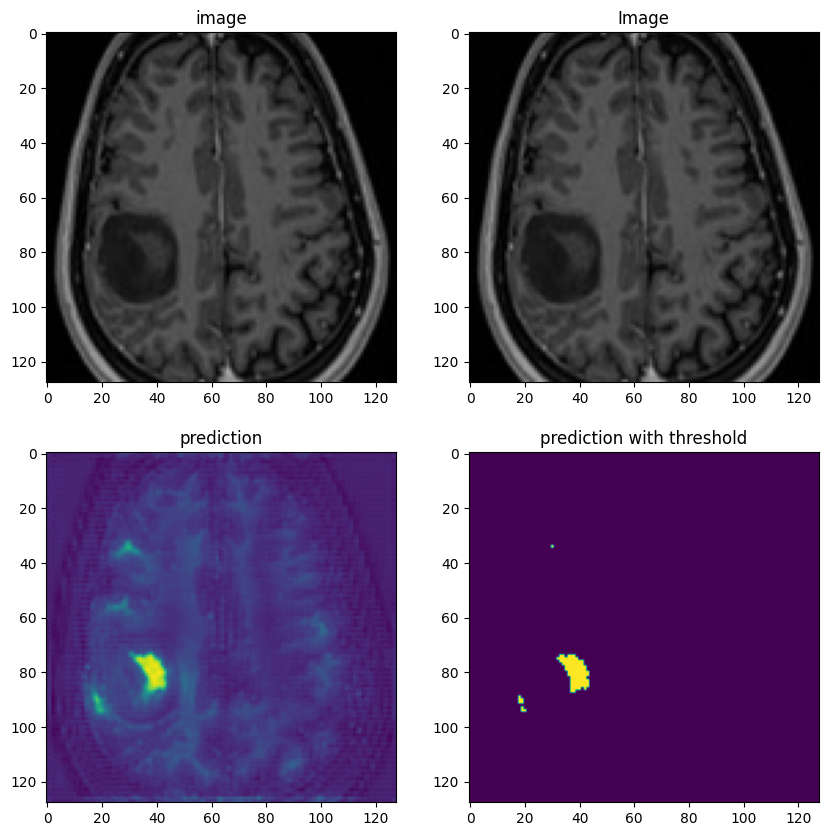

In [ ]:
image = cv2.imread("/content/mri_5.jpg", cv2.IMREAD_COLOR)
image = cv2.resize(image, (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(image)
ax[0, 1].set_title("Image")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

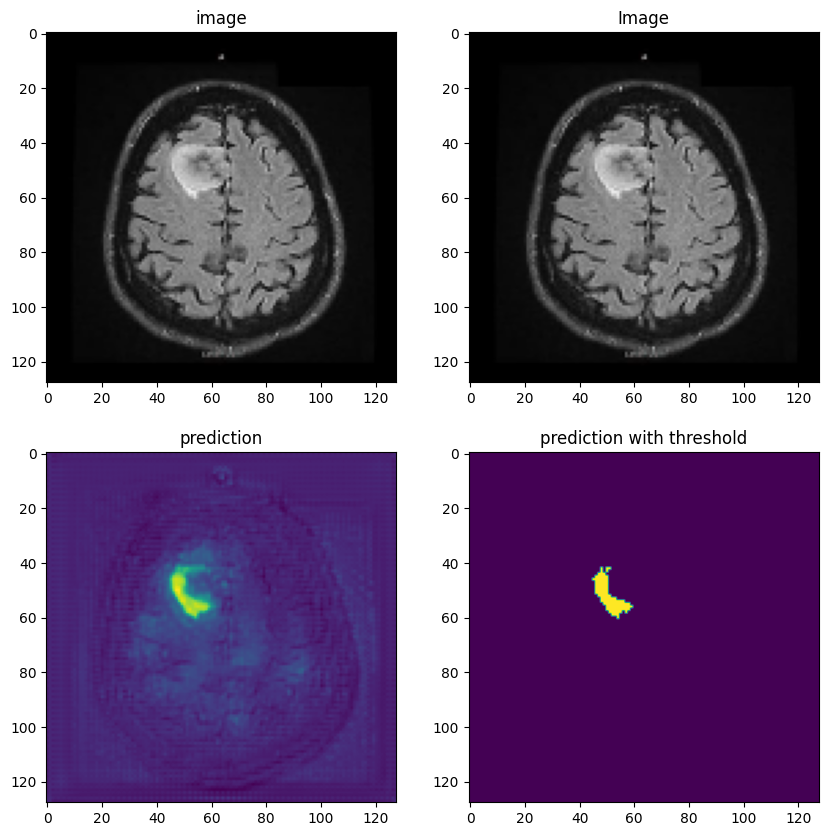

In [ ]:
image = cv2.imread("/content/mri_6.jpg", cv2.IMREAD_COLOR)
image = cv2.resize(image, (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(image)
ax[0, 1].set_title("Image")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

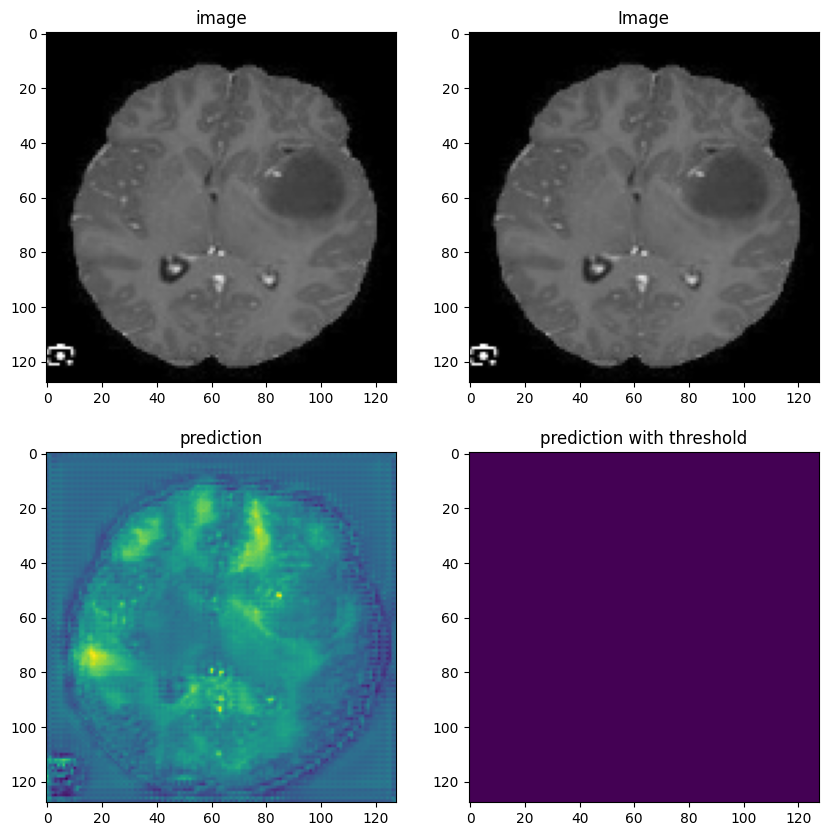

In [ ]:
image = cv2.imread("/content/mri_7.jpg", cv2.IMREAD_COLOR)
image = cv2.resize(image, (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(image)
ax[0, 1].set_title("Image")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

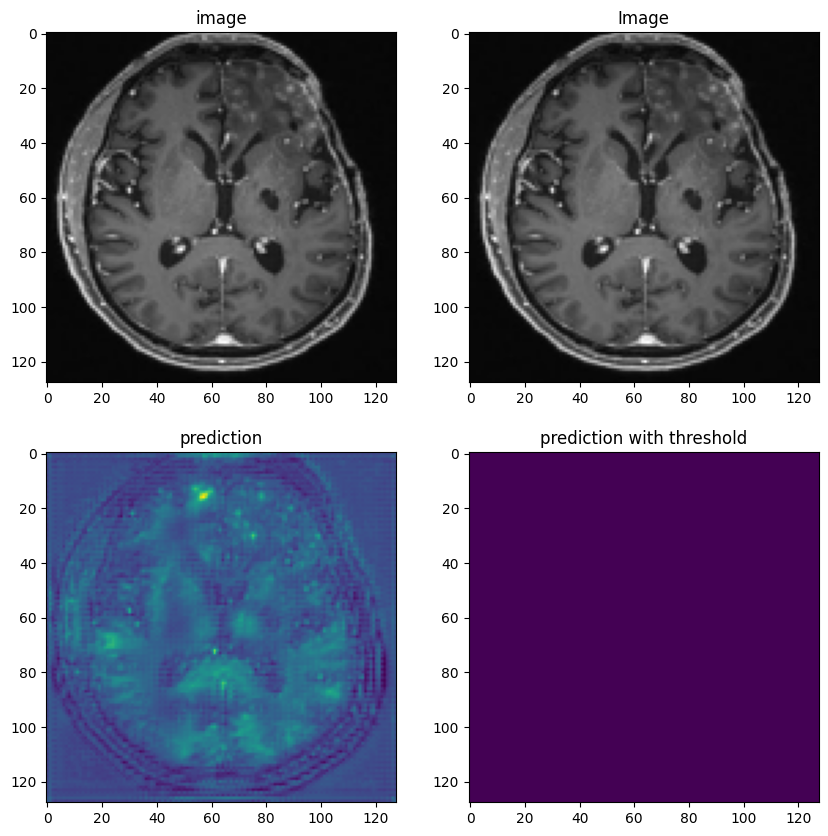

In [ ]:
image = cv2.imread("/content/mri_9.jpg", cv2.IMREAD_COLOR)
image = cv2.resize(image, (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(image)
ax[0, 1].set_title("Image")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

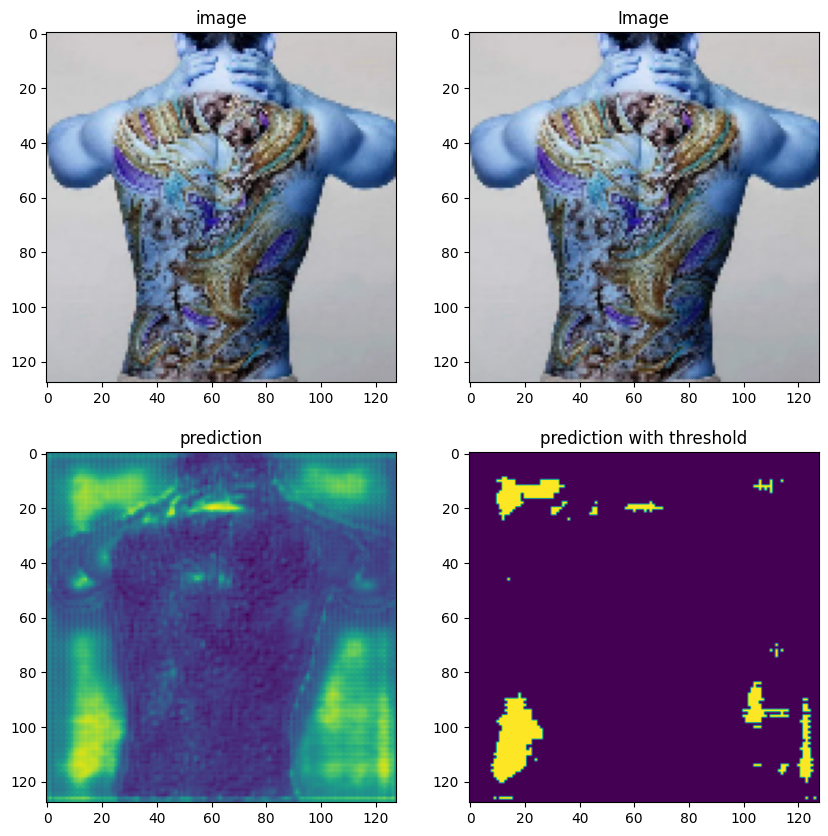

In [ ]:
image = cv2.imread("/content/mri_8.jpg", cv2.IMREAD_COLOR)
image = cv2.resize(image, (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(image)
ax[0, 1].set_title("Image")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()